<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:30] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


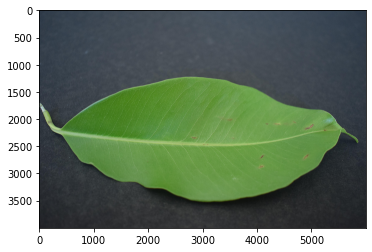

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

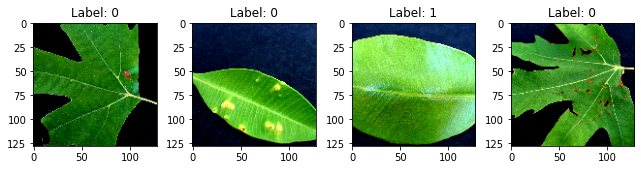

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:36] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:38] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2504865072998268 samples/sec                   batch loss = 0.6263541579246521 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2504377631069188 samples/sec                   batch loss = 0.9959964156150818 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2468852238980013 samples/sec                   batch loss = 0.3801378011703491 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2525360785397277 samples/sec                   batch loss = 0.49922963976860046 | accuracy = 0.625


Epoch[1] Batch[25] Speed: 1.2583400235929154 samples/sec                   batch loss = 1.0314711332321167 | accuracy = 0.64


Epoch[1] Batch[30] Speed: 1.2468397252276195 samples/sec                   batch loss = 0.6472044587135315 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.2588891723568696 samples/sec                   batch loss = 0.4816061556339264 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2553379233848927 samples/sec                   batch loss = 0.6000043749809265 | accuracy = 0.625


Epoch[1] Batch[45] Speed: 1.255805020011632 samples/sec                   batch loss = 1.2878165245056152 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2567451521138695 samples/sec                   batch loss = 0.45318710803985596 | accuracy = 0.62


Epoch[1] Batch[55] Speed: 1.2550841775324646 samples/sec                   batch loss = 0.743256151676178 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2609473540776808 samples/sec                   batch loss = 1.6352821588516235 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2398247847220554 samples/sec                   batch loss = 1.310901403427124 | accuracy = 0.6192307692307693


Epoch[1] Batch[70] Speed: 1.2391790930126474 samples/sec                   batch loss = 0.40025001764297485 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2395964126421986 samples/sec                   batch loss = 0.4247259497642517 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.256519068331978 samples/sec                   batch loss = 1.6802650690078735 | accuracy = 0.6125


Epoch[1] Batch[85] Speed: 1.25892072330769 samples/sec                   batch loss = 0.46516451239585876 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.2564090678061997 samples/sec                   batch loss = 0.4770292639732361 | accuracy = 0.625


Epoch[1] Batch[95] Speed: 1.2617031291444105 samples/sec                   batch loss = 0.7002972960472107 | accuracy = 0.6263157894736842


Epoch[1] Batch[100] Speed: 1.2658386044492027 samples/sec                   batch loss = 0.7925564646720886 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2540749998505025 samples/sec                   batch loss = 0.6774300932884216 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.2560567065205177 samples/sec                   batch loss = 0.5244020819664001 | accuracy = 0.6204545454545455


Epoch[1] Batch[115] Speed: 1.2582570697769824 samples/sec                   batch loss = 0.8222438097000122 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2580710061221534 samples/sec                   batch loss = 0.4076805114746094 | accuracy = 0.6166666666666667


Epoch[1] Batch[125] Speed: 1.2617034137974446 samples/sec                   batch loss = 0.7445707321166992 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.252950841599165 samples/sec                   batch loss = 0.6542223691940308 | accuracy = 0.6153846153846154


Epoch[1] Batch[135] Speed: 1.255737438165439 samples/sec                   batch loss = 0.6155785918235779 | accuracy = 0.6203703703703703


Epoch[1] Batch[140] Speed: 1.2571330347633984 samples/sec                   batch loss = 0.436227411031723 | accuracy = 0.6303571428571428


Epoch[1] Batch[145] Speed: 1.2602135928251752 samples/sec                   batch loss = 0.7790259718894958 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2574714857752103 samples/sec                   batch loss = 0.33625856041908264 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2579812019823016 samples/sec                   batch loss = 0.4681938886642456 | accuracy = 0.6387096774193548


Epoch[1] Batch[160] Speed: 1.2480105879804522 samples/sec                   batch loss = 0.8735520839691162 | accuracy = 0.6421875


Epoch[1] Batch[165] Speed: 1.251799275074518 samples/sec                   batch loss = 0.406389981508255 | accuracy = 0.646969696969697


Epoch[1] Batch[170] Speed: 1.2517518293867136 samples/sec                   batch loss = 0.587244987487793 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.253301743095649 samples/sec                   batch loss = 0.6606853008270264 | accuracy = 0.6442857142857142


Epoch[1] Batch[180] Speed: 1.2562666321023697 samples/sec                   batch loss = 0.8448251485824585 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.252736877867754 samples/sec                   batch loss = 0.44533243775367737 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.257042140077512 samples/sec                   batch loss = 0.3519827723503113 | accuracy = 0.6460526315789473


Epoch[1] Batch[195] Speed: 1.2572152751675116 samples/sec                   batch loss = 0.49620187282562256 | accuracy = 0.6487179487179487


Epoch[1] Batch[200] Speed: 1.259318930178919 samples/sec                   batch loss = 0.8975134491920471 | accuracy = 0.64875


Epoch[1] Batch[205] Speed: 1.2577835271238647 samples/sec                   batch loss = 1.12041175365448 | accuracy = 0.65


Epoch[1] Batch[210] Speed: 1.2373062691466752 samples/sec                   batch loss = 0.9192930459976196 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2337077230565143 samples/sec                   batch loss = 0.23391607403755188 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2513698732311584 samples/sec                   batch loss = 0.7713800668716431 | accuracy = 0.6534090909090909


Epoch[1] Batch[225] Speed: 1.264499004965075 samples/sec                   batch loss = 0.566262423992157 | accuracy = 0.65


Epoch[1] Batch[230] Speed: 1.260210090399399 samples/sec                   batch loss = 0.30611538887023926 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2550933789570897 samples/sec                   batch loss = 0.16770142316818237 | accuracy = 0.6595744680851063


Epoch[1] Batch[240] Speed: 1.259488060016232 samples/sec                   batch loss = 0.6511889100074768 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2618464207442865 samples/sec                   batch loss = 0.3276767432689667 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.256445857968402 samples/sec                   batch loss = 0.36717724800109863 | accuracy = 0.667


Epoch[1] Batch[255] Speed: 1.2575960009306855 samples/sec                   batch loss = 0.5934951305389404 | accuracy = 0.6666666666666666


Epoch[1] Batch[260] Speed: 1.2570242452631992 samples/sec                   batch loss = 0.3917941451072693 | accuracy = 0.6692307692307692


Epoch[1] Batch[265] Speed: 1.2563542158876553 samples/sec                   batch loss = 1.632704257965088 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2622267282717468 samples/sec                   batch loss = 0.8963899612426758 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.2554780816494002 samples/sec                   batch loss = 0.692552387714386 | accuracy = 0.6654545454545454


Epoch[1] Batch[280] Speed: 1.254790647790327 samples/sec                   batch loss = 0.4789634644985199 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2563115043314745 samples/sec                   batch loss = 0.4625866413116455 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.2554963082807287 samples/sec                   batch loss = 0.4052032232284546 | accuracy = 0.6655172413793103


Epoch[1] Batch[295] Speed: 1.250480169407807 samples/sec                   batch loss = 0.4745233654975891 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.2556898814493425 samples/sec                   batch loss = 0.38527464866638184 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2520805673657243 samples/sec                   batch loss = 0.4001115560531616 | accuracy = 0.6688524590163935


Epoch[1] Batch[310] Speed: 1.2517905888824041 samples/sec                   batch loss = 0.34475386142730713 | accuracy = 0.6693548387096774


Epoch[1] Batch[315] Speed: 1.25574646119006 samples/sec                   batch loss = 0.5694036483764648 | accuracy = 0.6706349206349206


Epoch[1] Batch[320] Speed: 1.257469695048225 samples/sec                   batch loss = 0.200076624751091 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.2553926865955538 samples/sec                   batch loss = 1.0066273212432861 | accuracy = 0.6684615384615384


Epoch[1] Batch[330] Speed: 1.2570172758417981 samples/sec                   batch loss = 0.7752605676651001 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2589379164076586 samples/sec                   batch loss = 0.3007128834724426 | accuracy = 0.6708955223880597


Epoch[1] Batch[340] Speed: 1.2578232268684435 samples/sec                   batch loss = 0.4166293740272522 | accuracy = 0.6720588235294118


Epoch[1] Batch[345] Speed: 1.259939232013955 samples/sec                   batch loss = 0.826218843460083 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.2403654081128184 samples/sec                   batch loss = 0.8833467364311218 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2413625526649255 samples/sec                   batch loss = 0.6930063962936401 | accuracy = 0.6725352112676056


Epoch[1] Batch[360] Speed: 1.2492582508286458 samples/sec                   batch loss = 0.3621627986431122 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2572614400175537 samples/sec                   batch loss = 0.9499906897544861 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2532853589514104 samples/sec                   batch loss = 0.37394335865974426 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.258855544940797 samples/sec                   batch loss = 1.5127732753753662 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.2596404954076683 samples/sec                   batch loss = 0.12488019466400146 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.2593556073593402 samples/sec                   batch loss = 0.416494756937027 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.258590272513506 samples/sec                   batch loss = 0.5082477331161499 | accuracy = 0.6717948717948717


Epoch[1] Batch[395] Speed: 1.25999193711672 samples/sec                   batch loss = 1.1969910860061646 | accuracy = 0.6708860759493671


Epoch[1] Batch[400] Speed: 1.2662652840297526 samples/sec                   batch loss = 0.6297933459281921 | accuracy = 0.670625


Epoch[1] Batch[405] Speed: 1.2527628826750432 samples/sec                   batch loss = 0.583051323890686 | accuracy = 0.671604938271605


Epoch[1] Batch[410] Speed: 1.256968680402914 samples/sec                   batch loss = 0.7736721038818359 | accuracy = 0.6731707317073171


Epoch[1] Batch[415] Speed: 1.2643672114622226 samples/sec                   batch loss = 0.9532873034477234 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2497490403344103 samples/sec                   batch loss = 0.48965561389923096 | accuracy = 0.675


Epoch[1] Batch[425] Speed: 1.2517050410005155 samples/sec                   batch loss = 0.4039511978626251 | accuracy = 0.6741176470588235


Epoch[1] Batch[430] Speed: 1.2538416295172508 samples/sec                   batch loss = 0.38762030005455017 | accuracy = 0.6755813953488372


Epoch[1] Batch[435] Speed: 1.2536500308794305 samples/sec                   batch loss = 0.3118840754032135 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.2521624283861426 samples/sec                   batch loss = 0.5200672149658203 | accuracy = 0.6755681818181818


Epoch[1] Batch[445] Speed: 1.2517500549130465 samples/sec                   batch loss = 0.6561734080314636 | accuracy = 0.6758426966292135


Epoch[1] Batch[450] Speed: 1.2547208291446275 samples/sec                   batch loss = 0.41755571961402893 | accuracy = 0.6788888888888889


Epoch[1] Batch[455] Speed: 1.2495468709967645 samples/sec                   batch loss = 0.2891487181186676 | accuracy = 0.6785714285714286


Epoch[1] Batch[460] Speed: 1.2526868356830088 samples/sec                   batch loss = 0.8569507002830505 | accuracy = 0.6793478260869565


Epoch[1] Batch[465] Speed: 1.2540833428077935 samples/sec                   batch loss = 0.879927396774292 | accuracy = 0.6790322580645162


Epoch[1] Batch[470] Speed: 1.2513102340524886 samples/sec                   batch loss = 0.47600415349006653 | accuracy = 0.6808510638297872


Epoch[1] Batch[475] Speed: 1.261415600300384 samples/sec                   batch loss = 0.25745442509651184 | accuracy = 0.6826315789473684


Epoch[1] Batch[480] Speed: 1.2581725228767797 samples/sec                   batch loss = 1.3476803302764893 | accuracy = 0.68125


Epoch[1] Batch[485] Speed: 1.2592942593599368 samples/sec                   batch loss = 0.5119835734367371 | accuracy = 0.6824742268041237


Epoch[1] Batch[490] Speed: 1.2659713735842706 samples/sec                   batch loss = 0.48218899965286255 | accuracy = 0.6816326530612244


Epoch[1] Batch[495] Speed: 1.261668876833615 samples/sec                   batch loss = 0.3489786982536316 | accuracy = 0.6823232323232323


Epoch[1] Batch[500] Speed: 1.2701117490145537 samples/sec                   batch loss = 0.36936891078948975 | accuracy = 0.6825


Epoch[1] Batch[505] Speed: 1.2634431421005434 samples/sec                   batch loss = 1.4925034046173096 | accuracy = 0.6836633663366337


Epoch[1] Batch[510] Speed: 1.2656034135623686 samples/sec                   batch loss = 0.11590953916311264 | accuracy = 0.6843137254901961


Epoch[1] Batch[515] Speed: 1.2636144285029545 samples/sec                   batch loss = 0.7708280086517334 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.2633083343015536 samples/sec                   batch loss = 0.9846084713935852 | accuracy = 0.6836538461538462


Epoch[1] Batch[525] Speed: 1.261609959619526 samples/sec                   batch loss = 0.8054690361022949 | accuracy = 0.6833333333333333


Epoch[1] Batch[530] Speed: 1.2626679860400105 samples/sec                   batch loss = 0.7694763541221619 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.2594392733556092 samples/sec                   batch loss = 0.28706154227256775 | accuracy = 0.6827102803738317


Epoch[1] Batch[540] Speed: 1.2675460927301119 samples/sec                   batch loss = 0.26802319288253784 | accuracy = 0.6847222222222222


Epoch[1] Batch[545] Speed: 1.2655077579899376 samples/sec                   batch loss = 0.5238483548164368 | accuracy = 0.6844036697247706


Epoch[1] Batch[550] Speed: 1.2644610745904101 samples/sec                   batch loss = 0.6654466390609741 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2551884056409657 samples/sec                   batch loss = 0.5344358682632446 | accuracy = 0.6869369369369369


Epoch[1] Batch[560] Speed: 1.2523001023876696 samples/sec                   batch loss = 0.5464385151863098 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2583888195126738 samples/sec                   batch loss = 0.6527499556541443 | accuracy = 0.6876106194690266


Epoch[1] Batch[570] Speed: 1.25730977542205 samples/sec                   batch loss = 0.8443038463592529 | accuracy = 0.6872807017543859


Epoch[1] Batch[575] Speed: 1.2531447537964897 samples/sec                   batch loss = 0.9065881371498108 | accuracy = 0.6873913043478261


Epoch[1] Batch[580] Speed: 1.2515592816468957 samples/sec                   batch loss = 0.2550278902053833 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2560638533704145 samples/sec                   batch loss = 0.6558024883270264 | accuracy = 0.6863247863247863


Epoch[1] Batch[590] Speed: 1.2604425232987664 samples/sec                   batch loss = 0.5776284337043762 | accuracy = 0.6872881355932203


Epoch[1] Batch[595] Speed: 1.2595192627691816 samples/sec                   batch loss = 0.6577529907226562 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2676854463847063 samples/sec                   batch loss = 0.1941496580839157 | accuracy = 0.6883333333333334


Epoch[1] Batch[605] Speed: 1.2683632088231038 samples/sec                   batch loss = 0.7237064838409424 | accuracy = 0.6867768595041323


Epoch[1] Batch[610] Speed: 1.259971214117624 samples/sec                   batch loss = 0.4140876531600952 | accuracy = 0.6860655737704918


Epoch[1] Batch[615] Speed: 1.2631361798667102 samples/sec                   batch loss = 0.2919812798500061 | accuracy = 0.6869918699186992


Epoch[1] Batch[620] Speed: 1.245465119964949 samples/sec                   batch loss = 0.5327349901199341 | accuracy = 0.6875


Epoch[1] Batch[625] Speed: 1.2349942075196392 samples/sec                   batch loss = 0.4842522144317627 | accuracy = 0.6888


Epoch[1] Batch[630] Speed: 1.2364787260888124 samples/sec                   batch loss = 0.36313697695732117 | accuracy = 0.6880952380952381


Epoch[1] Batch[635] Speed: 1.2586351220470993 samples/sec                   batch loss = 0.4726906418800354 | accuracy = 0.6877952755905512


Epoch[1] Batch[640] Speed: 1.2590514782351323 samples/sec                   batch loss = 0.29153984785079956 | accuracy = 0.688671875


Epoch[1] Batch[645] Speed: 1.2566444303063051 samples/sec                   batch loss = 0.43100640177726746 | accuracy = 0.6891472868217055


Epoch[1] Batch[650] Speed: 1.262669126395037 samples/sec                   batch loss = 0.5828964710235596 | accuracy = 0.6884615384615385


Epoch[1] Batch[655] Speed: 1.2626648500743087 samples/sec                   batch loss = 0.40416038036346436 | accuracy = 0.6881679389312977


Epoch[1] Batch[660] Speed: 1.2554319537253904 samples/sec                   batch loss = 0.45866379141807556 | accuracy = 0.6882575757575757


Epoch[1] Batch[665] Speed: 1.2614443378028806 samples/sec                   batch loss = 0.29240962862968445 | accuracy = 0.6894736842105263


Epoch[1] Batch[670] Speed: 1.262719018943853 samples/sec                   batch loss = 0.4131351411342621 | accuracy = 0.6906716417910448


Epoch[1] Batch[675] Speed: 1.2600225970506072 samples/sec                   batch loss = 0.5582530498504639 | accuracy = 0.6918518518518518


Epoch[1] Batch[680] Speed: 1.2541597469615593 samples/sec                   batch loss = 0.691220223903656 | accuracy = 0.6919117647058823


Epoch[1] Batch[685] Speed: 1.2583522930038253 samples/sec                   batch loss = 0.45647525787353516 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.2537672316978645 samples/sec                   batch loss = 0.753906786441803 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2534857430440356 samples/sec                   batch loss = 0.13095471262931824 | accuracy = 0.6902877697841726


Epoch[1] Batch[700] Speed: 1.25615676982064 samples/sec                   batch loss = 0.9032366871833801 | accuracy = 0.6907142857142857


Epoch[1] Batch[705] Speed: 1.2498413972655071 samples/sec                   batch loss = 0.7949320077896118 | accuracy = 0.6893617021276596


Epoch[1] Batch[710] Speed: 1.2547798554220833 samples/sec                   batch loss = 0.6870683431625366 | accuracy = 0.6904929577464789


Epoch[1] Batch[715] Speed: 1.252020393259341 samples/sec                   batch loss = 0.7892411947250366 | accuracy = 0.6912587412587412


Epoch[1] Batch[720] Speed: 1.2537305045436216 samples/sec                   batch loss = 0.3391384482383728 | accuracy = 0.6916666666666667


Epoch[1] Batch[725] Speed: 1.2537596424921673 samples/sec                   batch loss = 0.44249939918518066 | accuracy = 0.6917241379310345


Epoch[1] Batch[730] Speed: 1.2557241858331107 samples/sec                   batch loss = 0.38960471749305725 | accuracy = 0.6921232876712329


Epoch[1] Batch[735] Speed: 1.2539588661643173 samples/sec                   batch loss = 0.4754941463470459 | accuracy = 0.6928571428571428


Epoch[1] Batch[740] Speed: 1.248900126719635 samples/sec                   batch loss = 0.5754485130310059 | accuracy = 0.6925675675675675


Epoch[1] Batch[745] Speed: 1.2570221732649804 samples/sec                   batch loss = 0.45018288493156433 | accuracy = 0.6936241610738255


Epoch[1] Batch[750] Speed: 1.2544458530432276 samples/sec                   batch loss = 0.7337774038314819 | accuracy = 0.6933333333333334


Epoch[1] Batch[755] Speed: 1.2566362414858692 samples/sec                   batch loss = 0.10612992197275162 | accuracy = 0.6940397350993377


Epoch[1] Batch[760] Speed: 1.2500749573354173 samples/sec                   batch loss = 0.28011929988861084 | accuracy = 0.6947368421052632


Epoch[1] Batch[765] Speed: 1.2421296033054718 samples/sec                   batch loss = 0.43807512521743774 | accuracy = 0.6954248366013072


Epoch[1] Batch[770] Speed: 1.2388070567897522 samples/sec                   batch loss = 0.318859338760376 | accuracy = 0.6967532467532468


Epoch[1] Batch[775] Speed: 1.236960344566104 samples/sec                   batch loss = 0.3458746075630188 | accuracy = 0.6974193548387096


Epoch[1] Batch[780] Speed: 1.2588001958591957 samples/sec                   batch loss = 0.5480713844299316 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2544101178159832 samples/sec                   batch loss = 0.605074942111969 | accuracy = 0.6993630573248407


[Epoch 1] training: accuracy=0.6995558375634517
[Epoch 1] time cost: 655.1694192886353
[Epoch 1] validation: validation accuracy=0.7666666666666667


Epoch[2] Batch[5] Speed: 1.255390526035306 samples/sec                   batch loss = 0.37336233258247375 | accuracy = 0.85


Epoch[2] Batch[10] Speed: 1.2558079339961177 samples/sec                   batch loss = 0.4459957778453827 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2610753074832133 samples/sec                   batch loss = 0.3882027268409729 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.259759291984897 samples/sec                   batch loss = 0.3341764211654663 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2670507973058243 samples/sec                   batch loss = 0.4941595494747162 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.247143081529935 samples/sec                   batch loss = 0.14376594126224518 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2491167807524877 samples/sec                   batch loss = 0.4330321252346039 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2422523862719144 samples/sec                   batch loss = 0.6189330220222473 | accuracy = 0.78125


Epoch[2] Batch[45] Speed: 1.2551980781359535 samples/sec                   batch loss = 0.589805543422699 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.260790054368006 samples/sec                   batch loss = 0.1504492461681366 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2668952238959474 samples/sec                   batch loss = 0.500026285648346 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2662874570622977 samples/sec                   batch loss = 0.7319585084915161 | accuracy = 0.7666666666666667


Epoch[2] Batch[65] Speed: 1.2643352916449442 samples/sec                   batch loss = 0.9484904408454895 | accuracy = 0.7615384615384615


Epoch[2] Batch[70] Speed: 1.2677766414424403 samples/sec                   batch loss = 0.5733360648155212 | accuracy = 0.7607142857142857


Epoch[2] Batch[75] Speed: 1.2642668838532207 samples/sec                   batch loss = 0.5086517930030823 | accuracy = 0.7566666666666667


Epoch[2] Batch[80] Speed: 1.2607804849895634 samples/sec                   batch loss = 0.7239259481430054 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2631626182162163 samples/sec                   batch loss = 0.2342521697282791 | accuracy = 0.7529411764705882


Epoch[2] Batch[90] Speed: 1.2623484826995326 samples/sec                   batch loss = 0.555735170841217 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2585277717578962 samples/sec                   batch loss = 0.15114080905914307 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2615390006186176 samples/sec                   batch loss = 0.2108280509710312 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2606306152642768 samples/sec                   batch loss = 0.5747527480125427 | accuracy = 0.7642857142857142


Epoch[2] Batch[110] Speed: 1.2587056603062974 samples/sec                   batch loss = 0.5139195322990417 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2589969622220976 samples/sec                   batch loss = 0.5797960162162781 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2592814044503544 samples/sec                   batch loss = 0.32998567819595337 | accuracy = 0.7583333333333333


Epoch[2] Batch[125] Speed: 1.2599539927831258 samples/sec                   batch loss = 0.8465521335601807 | accuracy = 0.758


Epoch[2] Batch[130] Speed: 1.262722630367076 samples/sec                   batch loss = 0.647445023059845 | accuracy = 0.7461538461538462


Epoch[2] Batch[135] Speed: 1.2600107681956259 samples/sec                   batch loss = 0.37863874435424805 | accuracy = 0.7537037037037037


Epoch[2] Batch[140] Speed: 1.2645904093618736 samples/sec                   batch loss = 0.7569420337677002 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.2589872310907084 samples/sec                   batch loss = 0.44019949436187744 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.253428149465703 samples/sec                   batch loss = 0.2469976395368576 | accuracy = 0.7566666666666667


Epoch[2] Batch[155] Speed: 1.261503998383082 samples/sec                   batch loss = 0.5001097917556763 | accuracy = 0.7596774193548387


Epoch[2] Batch[160] Speed: 1.2613596465441657 samples/sec                   batch loss = 0.4369925260543823 | accuracy = 0.7578125


Epoch[2] Batch[165] Speed: 1.2618192782474618 samples/sec                   batch loss = 0.09015969187021255 | accuracy = 0.7621212121212121


Epoch[2] Batch[170] Speed: 1.267808160432305 samples/sec                   batch loss = 0.4052942097187042 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2444648840222914 samples/sec                   batch loss = 0.40669551491737366 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.238608686125303 samples/sec                   batch loss = 0.23859864473342896 | accuracy = 0.7611111111111111


Epoch[2] Batch[185] Speed: 1.2342402998215571 samples/sec                   batch loss = 0.21704591810703278 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2417182044262092 samples/sec                   batch loss = 0.29393938183784485 | accuracy = 0.7552631578947369


Epoch[2] Batch[195] Speed: 1.2609963524250398 samples/sec                   batch loss = 0.08303268998861313 | accuracy = 0.7551282051282051


Epoch[2] Batch[200] Speed: 1.2617103403941927 samples/sec                   batch loss = 0.3297085165977478 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.263511746245343 samples/sec                   batch loss = 0.6196731925010681 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.257957243800702 samples/sec                   batch loss = 0.336131751537323 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.2628446705998988 samples/sec                   batch loss = 0.7255401015281677 | accuracy = 0.7546511627906977


Epoch[2] Batch[220] Speed: 1.2597745215103524 samples/sec                   batch loss = 0.3589493930339813 | accuracy = 0.7545454545454545


Epoch[2] Batch[225] Speed: 1.2598299563086353 samples/sec                   batch loss = 0.4837396740913391 | accuracy = 0.7544444444444445


Epoch[2] Batch[230] Speed: 1.2633091904353282 samples/sec                   batch loss = 0.3361450731754303 | accuracy = 0.7554347826086957


Epoch[2] Batch[235] Speed: 1.2608465261333512 samples/sec                   batch loss = 0.4909379780292511 | accuracy = 0.7542553191489362


Epoch[2] Batch[240] Speed: 1.2619778790770417 samples/sec                   batch loss = 0.5523142218589783 | accuracy = 0.753125


Epoch[2] Batch[245] Speed: 1.2601419389622053 samples/sec                   batch loss = 0.2917649447917938 | accuracy = 0.7551020408163265


Epoch[2] Batch[250] Speed: 1.2643434858323308 samples/sec                   batch loss = 0.5703232884407043 | accuracy = 0.751


Epoch[2] Batch[255] Speed: 1.2614709899243022 samples/sec                   batch loss = 0.7304099202156067 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2642952750464318 samples/sec                   batch loss = 0.2762342691421509 | accuracy = 0.7557692307692307


Epoch[2] Batch[265] Speed: 1.2646181478244731 samples/sec                   batch loss = 0.9764878749847412 | accuracy = 0.7537735849056604


Epoch[2] Batch[270] Speed: 1.2631067946546208 samples/sec                   batch loss = 0.4405220150947571 | accuracy = 0.7546296296296297


Epoch[2] Batch[275] Speed: 1.2594802122944166 samples/sec                   batch loss = 0.2416909635066986 | accuracy = 0.7563636363636363


Epoch[2] Batch[280] Speed: 1.2563513934485155 samples/sec                   batch loss = 0.21801917254924774 | accuracy = 0.75625


Epoch[2] Batch[285] Speed: 1.2628287013776376 samples/sec                   batch loss = 0.7576058506965637 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2645673425636943 samples/sec                   batch loss = 0.3261568546295166 | accuracy = 0.7594827586206897


Epoch[2] Batch[295] Speed: 1.2606290996968428 samples/sec                   batch loss = 0.2219102680683136 | accuracy = 0.7601694915254237


Epoch[2] Batch[300] Speed: 1.2562626812420314 samples/sec                   batch loss = 0.5621827244758606 | accuracy = 0.7616666666666667


Epoch[2] Batch[305] Speed: 1.2623737482612205 samples/sec                   batch loss = 0.3978358507156372 | accuracy = 0.760655737704918


Epoch[2] Batch[310] Speed: 1.2642611676598063 samples/sec                   batch loss = 1.4353094100952148 | accuracy = 0.7580645161290323


Epoch[2] Batch[315] Speed: 1.2690993897705265 samples/sec                   batch loss = 0.3022504448890686 | accuracy = 0.7595238095238095


Epoch[2] Batch[320] Speed: 1.2551241765434324 samples/sec                   batch loss = 0.7870736718177795 | accuracy = 0.7578125


Epoch[2] Batch[325] Speed: 1.2436541984593623 samples/sec                   batch loss = 0.2804200053215027 | accuracy = 0.7607692307692308


Epoch[2] Batch[330] Speed: 1.2353555881503997 samples/sec                   batch loss = 0.367755264043808 | accuracy = 0.7598484848484849


Epoch[2] Batch[335] Speed: 1.2514855278382013 samples/sec                   batch loss = 0.645395815372467 | accuracy = 0.7567164179104477


Epoch[2] Batch[340] Speed: 1.2688525257191363 samples/sec                   batch loss = 0.21398580074310303 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.2626008037584486 samples/sec                   batch loss = 0.49921151995658875 | accuracy = 0.755072463768116


Epoch[2] Batch[350] Speed: 1.2578311482575248 samples/sec                   batch loss = 0.04437493160367012 | accuracy = 0.7557142857142857


Epoch[2] Batch[355] Speed: 1.2694953213831652 samples/sec                   batch loss = 0.8112379312515259 | accuracy = 0.7514084507042254


Epoch[2] Batch[360] Speed: 1.2699422534557736 samples/sec                   batch loss = 0.3492128551006317 | accuracy = 0.7493055555555556


Epoch[2] Batch[365] Speed: 1.261168966877846 samples/sec                   batch loss = 0.4978715181350708 | accuracy = 0.7493150684931507


Epoch[2] Batch[370] Speed: 1.2603396931202129 samples/sec                   batch loss = 0.5332970023155212 | accuracy = 0.7486486486486487


Epoch[2] Batch[375] Speed: 1.2637576786206997 samples/sec                   batch loss = 0.3798070549964905 | accuracy = 0.75


Epoch[2] Batch[380] Speed: 1.2603503919791754 samples/sec                   batch loss = 0.5707979202270508 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2601430747590892 samples/sec                   batch loss = 0.5379340052604675 | accuracy = 0.7480519480519481


Epoch[2] Batch[390] Speed: 1.2596353884138611 samples/sec                   batch loss = 0.45714202523231506 | accuracy = 0.7474358974358974


Epoch[2] Batch[395] Speed: 1.2564400240905063 samples/sec                   batch loss = 0.43792885541915894 | accuracy = 0.7455696202531645


Epoch[2] Batch[400] Speed: 1.259225356330594 samples/sec                   batch loss = 0.28406786918640137 | accuracy = 0.746875


Epoch[2] Batch[405] Speed: 1.254746634862511 samples/sec                   batch loss = 0.6007910370826721 | accuracy = 0.7469135802469136


Epoch[2] Batch[410] Speed: 1.2614634020170523 samples/sec                   batch loss = 0.4464784562587738 | accuracy = 0.7469512195121951


Epoch[2] Batch[415] Speed: 1.2582427261989733 samples/sec                   batch loss = 0.8334900140762329 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.258041761769685 samples/sec                   batch loss = 0.5103834867477417 | accuracy = 0.7476190476190476


Epoch[2] Batch[425] Speed: 1.2573026143868729 samples/sec                   batch loss = 0.690585732460022 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2603285210542843 samples/sec                   batch loss = 0.19896192848682404 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2598506746613627 samples/sec                   batch loss = 0.4637245535850525 | accuracy = 0.7482758620689656


Epoch[2] Batch[440] Speed: 1.2558612340981434 samples/sec                   batch loss = 0.6449248194694519 | accuracy = 0.7488636363636364


Epoch[2] Batch[445] Speed: 1.2676281688029518 samples/sec                   batch loss = 0.5458189845085144 | accuracy = 0.7471910112359551


Epoch[2] Batch[450] Speed: 1.2623788774837081 samples/sec                   batch loss = 0.4850720763206482 | accuracy = 0.7461111111111111


Epoch[2] Batch[455] Speed: 1.2660303167230966 samples/sec                   batch loss = 0.5104053020477295 | accuracy = 0.7450549450549451


Epoch[2] Batch[460] Speed: 1.2660057643759455 samples/sec                   batch loss = 0.27585792541503906 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.242238497243224 samples/sec                   batch loss = 0.6237821578979492 | accuracy = 0.7446236559139785


Epoch[2] Batch[470] Speed: 1.241365216309747 samples/sec                   batch loss = 0.23857060074806213 | accuracy = 0.7462765957446809


Epoch[2] Batch[475] Speed: 1.2399830364640636 samples/sec                   batch loss = 0.22527481615543365 | accuracy = 0.7473684210526316


Epoch[2] Batch[480] Speed: 1.2658621952032914 samples/sec                   batch loss = 0.20103898644447327 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2620954079787294 samples/sec                   batch loss = 1.2926661968231201 | accuracy = 0.7458762886597938


Epoch[2] Batch[490] Speed: 1.2625069315832695 samples/sec                   batch loss = 0.26862090826034546 | accuracy = 0.746938775510204


Epoch[2] Batch[495] Speed: 1.263731786493919 samples/sec                   batch loss = 0.47881969809532166 | accuracy = 0.7459595959595959


Epoch[2] Batch[500] Speed: 1.2603509600652607 samples/sec                   batch loss = 0.623880922794342 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2629558009552482 samples/sec                   batch loss = 0.49935975670814514 | accuracy = 0.7465346534653465


Epoch[2] Batch[510] Speed: 1.2565760051673467 samples/sec                   batch loss = 0.4259112775325775 | accuracy = 0.7455882352941177


Epoch[2] Batch[515] Speed: 1.2602901777581967 samples/sec                   batch loss = 0.36081650853157043 | accuracy = 0.7466019417475728


Epoch[2] Batch[520] Speed: 1.2633169908187245 samples/sec                   batch loss = 0.2356567680835724 | accuracy = 0.7471153846153846


Epoch[2] Batch[525] Speed: 1.261685860433937 samples/sec                   batch loss = 0.27767637372016907 | accuracy = 0.7466666666666667


Epoch[2] Batch[530] Speed: 1.2632781801077022 samples/sec                   batch loss = 0.3194139897823334 | accuracy = 0.7466981132075472


Epoch[2] Batch[535] Speed: 1.2655429827612439 samples/sec                   batch loss = 0.8279377818107605 | accuracy = 0.7481308411214953


Epoch[2] Batch[540] Speed: 1.2609728479070015 samples/sec                   batch loss = 0.493996798992157 | accuracy = 0.7467592592592592


Epoch[2] Batch[545] Speed: 1.2585607207783547 samples/sec                   batch loss = 0.48920801281929016 | accuracy = 0.7467889908256881


Epoch[2] Batch[550] Speed: 1.2638576397994095 samples/sec                   batch loss = 0.20445440709590912 | accuracy = 0.7477272727272727


Epoch[2] Batch[555] Speed: 1.2623221733963064 samples/sec                   batch loss = 0.3756105303764343 | accuracy = 0.7472972972972973


Epoch[2] Batch[560] Speed: 1.2572162172734203 samples/sec                   batch loss = 0.8661077618598938 | accuracy = 0.746875


Epoch[2] Batch[565] Speed: 1.2573322012967658 samples/sec                   batch loss = 0.7013798356056213 | accuracy = 0.7469026548672566


Epoch[2] Batch[570] Speed: 1.2554606071286525 samples/sec                   batch loss = 0.12365159392356873 | accuracy = 0.7473684210526316


Epoch[2] Batch[575] Speed: 1.258764778778896 samples/sec                   batch loss = 0.46365952491760254 | accuracy = 0.7473913043478261


Epoch[2] Batch[580] Speed: 1.2637880461065405 samples/sec                   batch loss = 0.5031583309173584 | accuracy = 0.7487068965517242


Epoch[2] Batch[585] Speed: 1.2548875997354276 samples/sec                   batch loss = 0.32129642367362976 | accuracy = 0.7495726495726496


Epoch[2] Batch[590] Speed: 1.2614808543401992 samples/sec                   batch loss = 0.9240273237228394 | accuracy = 0.7483050847457627


Epoch[2] Batch[595] Speed: 1.266594136205924 samples/sec                   batch loss = 1.3398102521896362 | accuracy = 0.7487394957983193


Epoch[2] Batch[600] Speed: 1.260489777782653 samples/sec                   batch loss = 0.391408771276474 | accuracy = 0.75


Epoch[2] Batch[605] Speed: 1.2644485904673546 samples/sec                   batch loss = 0.7776463031768799 | accuracy = 0.7508264462809917


Epoch[2] Batch[610] Speed: 1.2429311193733403 samples/sec                   batch loss = 0.1970078945159912 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.243535193772042 samples/sec                   batch loss = 0.29634958505630493 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.2381402202867884 samples/sec                   batch loss = 0.3518936038017273 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.2381538350725345 samples/sec                   batch loss = 0.27609047293663025 | accuracy = 0.7532


Epoch[2] Batch[630] Speed: 1.2454198173234574 samples/sec                   batch loss = 0.563628077507019 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2666699685076845 samples/sec                   batch loss = 0.4002331495285034 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2722518742667035 samples/sec                   batch loss = 0.31233036518096924 | accuracy = 0.753125


Epoch[2] Batch[645] Speed: 1.269572942560831 samples/sec                   batch loss = 0.5070998072624207 | accuracy = 0.7531007751937985


Epoch[2] Batch[650] Speed: 1.2719779369976825 samples/sec                   batch loss = 0.78964763879776 | accuracy = 0.7534615384615385


Epoch[2] Batch[655] Speed: 1.2681782665147725 samples/sec                   batch loss = 0.5157163143157959 | accuracy = 0.7541984732824427


Epoch[2] Batch[660] Speed: 1.2689122173185947 samples/sec                   batch loss = 0.747025191783905 | accuracy = 0.7553030303030303


Epoch[2] Batch[665] Speed: 1.255530696046869 samples/sec                   batch loss = 0.6913595199584961 | accuracy = 0.7545112781954887


Epoch[2] Batch[670] Speed: 1.2678581725016083 samples/sec                   batch loss = 0.2547822892665863 | accuracy = 0.7544776119402985


Epoch[2] Batch[675] Speed: 1.2641049450527924 samples/sec                   batch loss = 0.3522448241710663 | accuracy = 0.7548148148148148


Epoch[2] Batch[680] Speed: 1.2646866889689488 samples/sec                   batch loss = 0.9183144569396973 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.266618902630067 samples/sec                   batch loss = 0.9980788826942444 | accuracy = 0.7532846715328467


Epoch[2] Batch[690] Speed: 1.2606813888792456 samples/sec                   batch loss = 0.2906569838523865 | accuracy = 0.7547101449275362


Epoch[2] Batch[695] Speed: 1.257480910738143 samples/sec                   batch loss = 0.5143097043037415 | accuracy = 0.7546762589928058


Epoch[2] Batch[700] Speed: 1.2621713672170989 samples/sec                   batch loss = 0.8052831888198853 | accuracy = 0.7546428571428572


Epoch[2] Batch[705] Speed: 1.2651870068920394 samples/sec                   batch loss = 0.2704797685146332 | accuracy = 0.7560283687943262


Epoch[2] Batch[710] Speed: 1.2660681502195386 samples/sec                   batch loss = 0.28821930289268494 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2614008052651395 samples/sec                   batch loss = 0.5913324952125549 | accuracy = 0.7555944055944056


Epoch[2] Batch[720] Speed: 1.266247794642415 samples/sec                   batch loss = 0.707603931427002 | accuracy = 0.7555555555555555


Epoch[2] Batch[725] Speed: 1.2623078319636125 samples/sec                   batch loss = 0.6154590249061584 | accuracy = 0.7544827586206897


Epoch[2] Batch[730] Speed: 1.2607516829845127 samples/sec                   batch loss = 0.070558100938797 | accuracy = 0.7551369863013698


Epoch[2] Batch[735] Speed: 1.2567542837675236 samples/sec                   batch loss = 0.25096264481544495 | accuracy = 0.7554421768707483


Epoch[2] Batch[740] Speed: 1.252132710476791 samples/sec                   batch loss = 0.4122432470321655 | accuracy = 0.7547297297297297


Epoch[2] Batch[745] Speed: 1.26124765910652 samples/sec                   batch loss = 0.18274793028831482 | accuracy = 0.7540268456375839


Epoch[2] Batch[750] Speed: 1.2584649940156736 samples/sec                   batch loss = 0.28866738080978394 | accuracy = 0.754


Epoch[2] Batch[755] Speed: 1.2605873283038223 samples/sec                   batch loss = 0.24165327847003937 | accuracy = 0.7549668874172185


Epoch[2] Batch[760] Speed: 1.2695896592546045 samples/sec                   batch loss = 0.6227754354476929 | accuracy = 0.7555921052631579


Epoch[2] Batch[765] Speed: 1.2631821148304119 samples/sec                   batch loss = 1.654151439666748 | accuracy = 0.7555555555555555


Epoch[2] Batch[770] Speed: 1.2417643410758616 samples/sec                   batch loss = 0.5137510895729065 | accuracy = 0.7555194805194805


Epoch[2] Batch[775] Speed: 1.236849820851868 samples/sec                   batch loss = 1.068579077720642 | accuracy = 0.7548387096774194


Epoch[2] Batch[780] Speed: 1.2400720307228195 samples/sec                   batch loss = 0.6395959258079529 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.2552628783060866 samples/sec                   batch loss = 0.28005051612854004 | accuracy = 0.7563694267515924


[Epoch 2] training: accuracy=0.7563451776649747
[Epoch 2] time cost: 643.1461818218231
[Epoch 2] validation: validation accuracy=0.7666666666666667


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)